

**Machine Learning I (Semester 1 2024)**
# Tutorial Session 2: Statistical Learning

*N. Hernitschek*



This Jupyter notebook gives an introduction to frequentist and Bayesian statistical inference and Maximum Likelihood Estimation.

It is based on code from the textbook

Statistics, Data Mining and Machine Learning in Astronomy: A Practical Python Guide for the Analysis of
Survey Data - Z. Ivezic, A. J. Connolly, J. T. VanderPlas, A. Gray

as well as on the "Inference" lectures of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540) and J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html). 

***Exercises required for class participation are in <font color='red'>red</font>.***

---
## Contents
* [Frequentist Approach: Maximum Likelihood Estimation](#first-bullet)
* [Quantifying Estimate Uncertainty](#second-bullet)
* [Bayesian Approach: Maximum Likelihood Estimation](#third-bullet)


## 1. Frequentist Approach: Maximum Likelihood Estimation <a class="anchor" id="first-bullet"></a>

This is an example for maximum likelihood estimation that uses the frequentist approach.

### The Flux of a Star

Imagine that we point our telescope to the sky, and observe the light coming from a single star. We'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{true}$.
We'll also ignore effects leading to systematic errors. 

We perform a series of $N$ measurements with our (perfect) telescope, where the $i^{th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is: Given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux $F_{true}$?

We use Python to generate some toy data to demonstrate the frequentist approaches to the problem (in the next lecture we will compare this to the Bayesian approach). 
As the measurements are number counts, a Poisson distribution is a good approximation to the measurement process:

In [13]:
# Generating some simple photon count data

import numpy as np
from scipy import stats
#np.random.seed(1)  # for repeatability

F_true = 28  # true flux, say number of photons measured in 1 second
N = 500 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root



We make a simple visualization of the "measured" data:


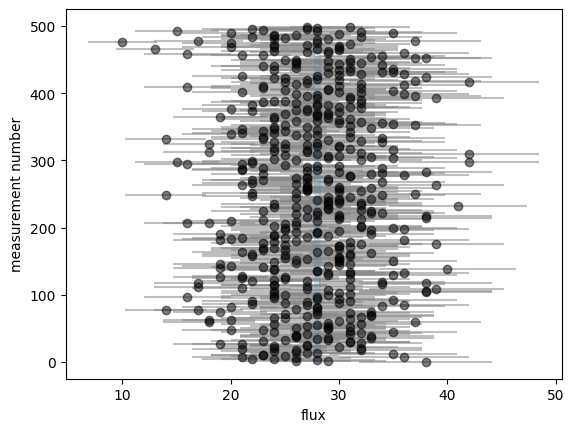

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.errorbar(F, np.arange(N), xerr=e, fmt='ok', ecolor='gray', alpha=0.5)
ax.vlines([F_true], 0, N, linewidth=5, alpha=0.2)
ax.set_xlabel("flux");ax.set_ylabel("measurement number");


These measurements each have a different error $e_i$ which is estimated from Poisson statistics using the standard square-root rule. Here, as we generate data for this toy example, we already know the true flux $F_{true}$, but the question is this: 

Given our measurements and errors, what is our best estimate of the true flux?

We take here a look at the frequentist approach to solve this problem.

### Frequentist Approach to Estimating the Flux

Given a single observation $D_i=(F_i,e_i)$, we can compute the probability distribution of the measurement given the true flux $F_{true}$ given our assumption of Gaussian errors:

$$P(D_i|F_{true}) = \frac{1}{\sqrt{2\pi e_i^2}}\exp \left( \frac{-(F_i-F_{true})^2}{2e_i^2}     \right)    $$

This should be read "the probability of $D_i$ given $F_{true}$ equals ...". You should recognize this as a normal distribution with mean $F_{true}$ and standard deviation $e_i$.

We then construct the likelihood function for our maximum likelihood approach by computing the product of the probabilities for each data point:

$$L(D|F_{true}) = \prod_{i=1}^N P(D_i|F_{true})$$



Here $D={D_i}$ represents the entire set of measurements. As likelihood values often become very small, it is more convenient to instead compute the log-likelihood. Combining the previous two equations and computing the log, we have

$$
\log L = \frac{1}{2}\sum_{i=1}^N \left[ \log(2 \pi e_i^2)+\frac{(F_i-F_{true})^2}{e_i^2}   \right]
$$


We have to determine $F_{true}$ such that the likelihood is maximized. For this simple problem, the maximization can be computed analytically (i.e. by setting $d \log L/ d F_{true} =0$). This results in the following observed estimate of $F_{true}$:

$$F_{est} = \frac{\sum w_i F_i}{\sum w_i }    $$ with $w_i=1/e_i^2$

Notice that in the special case of all errors $e_i$ being equal, this reduces to
$$F_{est} = \frac{1}{N} \sum_{i=1}^N F_i$$

That is, in agreement with intuition, $F_{est}$ is simply the mean of the observed data when errors are equal.

We can go further and ask what the error of our estimate is. In the frequentist approach, this can be accomplished by fitting a Gaussian approximation to the likelihood curve at maximum. In this simple case this can also be solved analytically. It can be shown that the standard deviation of this Gaussian approximation is:
    
$$\sigma_{est} = \left(\sum_{i=1}^N w_i \right)^{-1/2}$$

This gives fairly simple calculations; let's evaluate them for our toy dataset:

In [15]:
w = 1. / e ** 2
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, (w * F).sum() / w.sum(), w.sum() ** -0.5, N))



      F_true = 28
      F_est  = 27 +/- 0 (based on 500 measurements)
      


We thus find that for 50 measurements of the flux, our estimate has an error of about 4% and is consistent with the input value.

## 2. Quantifying Estimate Uncertainty <a class="anchor" id="second-bullet"></a>


Our MLE of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the shape and distribution of the likelihood function, but we'd like to capture that with a few numbers.

The ***asymptotic normality of MLE*** is invoked to approximate the likelihood function as a Gaussian (or the $\ln L$ as a parabola), i.e. we take a Taylor expansion around the MLE, keep terms up $2^\mathrm{nd}$ order, then *define* the uncertainty on our model parameters as:

$$\sigma_{jk} = \sqrt{[F^{-1}]_{jk}}, $$

where

$$ F_{jk} = - \frac{d^2}{d\theta_j} \frac{\ln L}{d\theta_k} \Biggr\rvert_{\theta=\hat \theta}.$$

The matrix $F$ is known as the **observed Fisher information matrix**. The elements $\sigma^2_{jk}$ are known as the ***covariance matrix***.

The marginal error bars for each parameter, $\theta_i$ are given by the diagonal elements, $\sigma_{ii}$. These are the "error bars" that are typically quoted with each measurement. Off diagonal elements, $\sigma_{ij}$, arise from any correlation between the parameters in the model.

In our example of a homoscedastic Gaussian, the uncertainly on the mean is 

$$\sigma_{\mu} = \left( - \frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu}\right)^{-1/2}$$

We find

$$\frac{d^2\ln L(\mu)}{d\mu^2}\Biggr\rvert_{\hat \mu} = - \sum_{i=1}^N\frac{1}{\sigma^2} = -\frac{N}{\sigma^2},$$

since, again, $\sigma = {\rm constant}$.  

Then 

$$\sigma_{\mu} = \frac{\sigma}{\sqrt{N}}.$$

So, our estimator of $\mu$ is $\overline{x}\pm\frac{\sigma}{\sqrt{N}}$, which is a result that you should be familiar with. 

Let's check this:
In the following, we 
- do a rough $2^\mathrm{nd}$ order differentation of our log-likelihood function with `np.diff`, 
- divide by our $\Delta \theta^2$ to get the correct normalization, 
- multiply by $-1$, 
- then take the square root.

First, we are going to draw a sample of ${x_i}$ from a Gaussian and compute the likelihood.

<font color='red'>We generate a sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: $\mathscr{N}(\mu,\sigma)$</font>

In [18]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

#from astroML.plotting import setup_text_plots
#setup_text_plots(fontsize=10, usetex=True)

N = 3#30
mu = 1.0
sigma = 0.2
np.random.seed(42)
sample = norm(mu,sigma).rvs(size = N)
print(sample)

[1.09934283 0.97234714 1.12953771]


our sample is: [1.09934283 0.97234714 1.12953771]

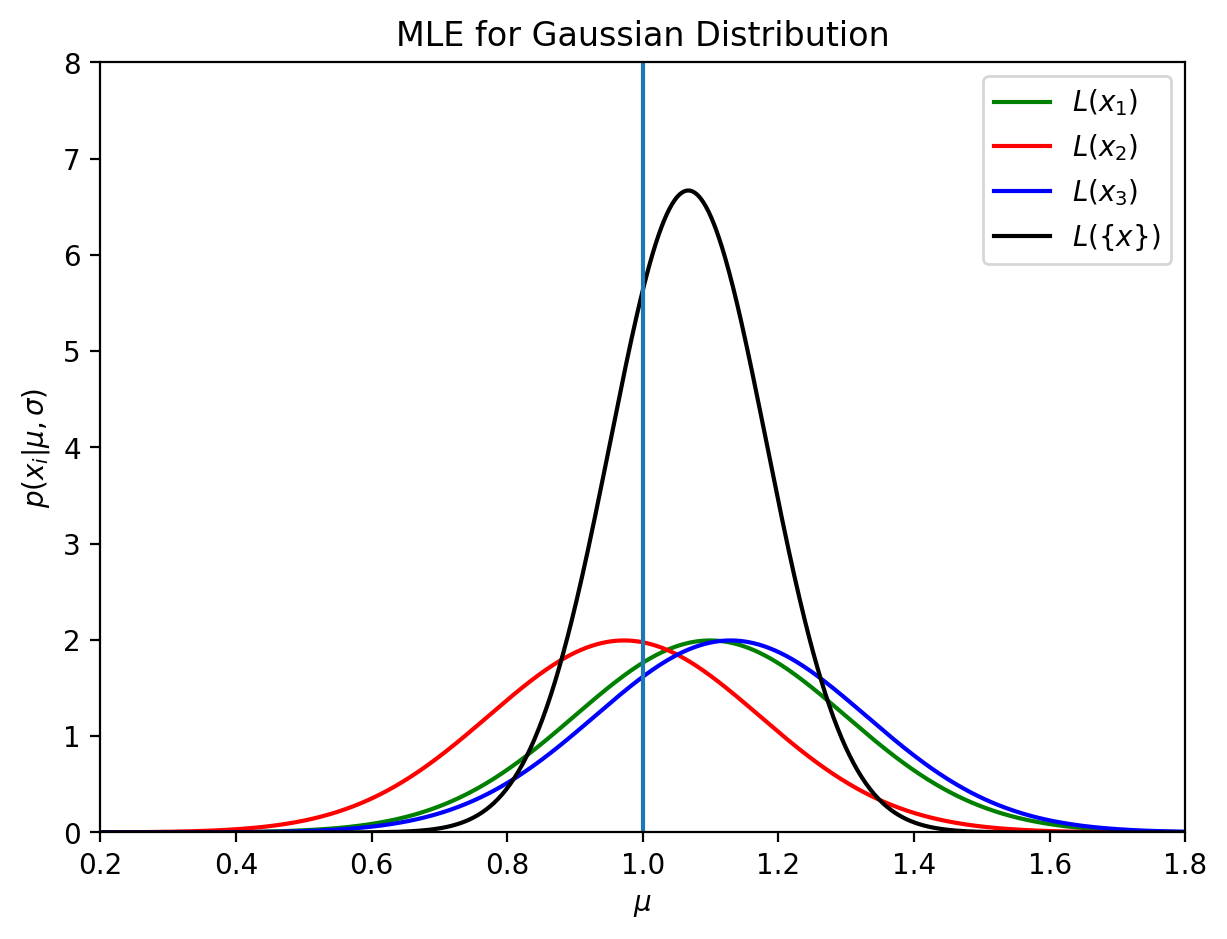

In [19]:
# calculate the likelihoods and plot them
xgrid = np.linspace(0,2,1000)
#here use the locations from above
L1 = norm.pdf(xgrid,loc=1.09934283,scale=0.2) #This is a Gaussian PDF sampled uniformly, centered at a specific location.
L2 = norm.pdf(xgrid,loc=0.97234714,scale=0.2)
L3 = norm.pdf(xgrid,loc=1.12953771,scale=0.2)
L = L1*L2*L3 #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(xgrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(xgrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(xgrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(xgrid, L, ls='-', c='black', label=r'$L(\{x\})$')
plt.axvline(x=mu)
plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel(r'$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

We see in this plot that our ML estimate of $\mu$ is not perfect. The uncertaintly of the estimate is captured by the likelihood function.

We now calculate the uncertainties.
<font color='red'>Think about it, and execute the following cell</font>

In [20]:
sigma_mu = np.diff(np.log(L), n=2)    #this calculates differences like: out[i] = a[i+1] - a[i] 
sigma_mu /= (xgrid[1]-xgrid[0])**2
sigma_mu *= -1
sigma_mu = 1/np.sqrt(sigma_mu)[0]

estimate_mu = xgrid[np.argmax(L)]
print("Likelihood is maximized at %.3f" % estimate_mu)
print("Fisher matrix error on estimated mean is %.3f" % sigma_mu)

Likelihood is maximized at 1.067
Fisher matrix error on estimated mean is 0.115


Let's plot a Gaussian at the measured $\mu$ with this error as the scale to see if it matches the numerical likelihood distribution for the three data points above.

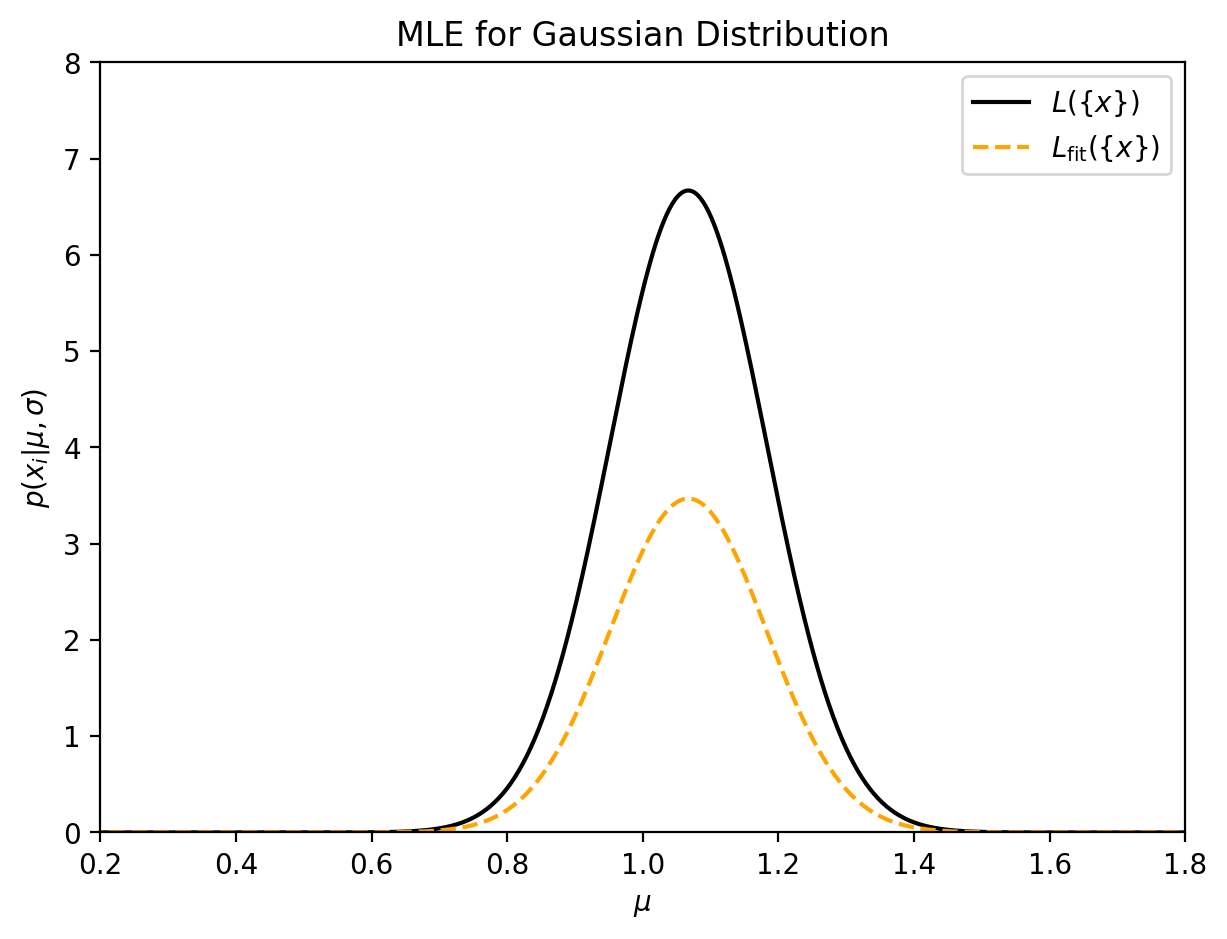

In [18]:
# Execute the following cell

xgrid = np.linspace(0.0,2.0,1000)
L = np.prod([L1,L2,L3],axis=0) # Total L is ???
# complete the following for measured mean and Fisher error
Lfit = norm.pdf(xgrid,loc=estimate_mu,scale=0.115)  

fig, ax = plt.subplots(figsize=(7, 5))

# plot numerical likelihood
plt.plot(xgrid, L, ls='-', c='black', 
         label=r'$L(\{x\})$')

# plot fitted Gaussian
plt.plot(xgrid, Lfit, ls='dashed', 
         c='orange', label=r'$L_\mathrm{fit}(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()


### What is $\pm \sigma$? Errors as Gaussian Approximations to the Likelihood Function

The $(\hat \mu - \sigma_\mu, \hat \mu + \sigma_\mu)$ range gives us a **confidence interval**.

In frequentist interpretation, if we repeated the same measurement a hundred times, we'd find for 68 experiments the true value was within their computed confidence intervals ($1 \sigma$ errors).


## 3. Bayesian Approach: Maximum Likelihood Estimation <a class="anchor" id="first-bullet"></a>

This is an example for MLE using the Bayesian approach.

### The Flux of a Star

We use the same example we had seen before with the frequentist approach:


Imagine that we point our telescope to the sky, and observe the light coming from a single star. We'll assume that the star's true flux is constant with time, i.e. that is it has a fixed value $F_{true}$.
We'll also ignore effects leading to systematic errors. 

We perform a series of $N$ measurements with our (perfect) telescope, where the $i^{th}$ measurement reports the observed photon flux $F_i$ and error $e_i$.

The question is: Given this set of measurements $D=\{F_i,e_i\}$, what is our best estimate of the true flux $F_{true}$?



For a one parameter problem like here, it's as simple as computing the posterior probability $P(F_{true} | D)$ as a function of $F_{true}$: this is the distribution reflecting our knowledge of the parameter $F_{true}$. But with growing **model dimensions**, this direct approach becomes increasingly intractable. For this reason, Bayesian calculations often depend on **sampling methods such as Markov Chain Monte Carlo (MCMC)**. 

We won't go into the details of the theory of MCMC here. 

Instead here we will see a practical example of applying an MCMC approach using the `emcee` package. Keep in mind here that the goal is to generate a set of points drawn from the posterior probability distribution, and to use those points to determine the answer we seek.

To perform this MCMC, we start by defining Python functions for the prior $P(F_{true})$, the likelihood $P(D | F_{true})$, and the posterior $P(F_{true} | D)$.
The model we use here is one-dimensional, but to handle multi-dimensional models we'll define the model in terms of an array of parameters $\theta$, which in this case is `theta=[Ftrue]`.


***BEFORE YOU START:*** Please install the package `emcee`before going through today's notebook. Make sure this notebook is in the correct Python kernel you are using before executing each of the following cells in turn. 

In [22]:
!pip3 install emcee

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 KB 414.2 kB/s eta 0:00:001m451.7 kB/s eta 0:00:01


As before, we use Python to generate some toy data to demonstrate the frequentist approaches to the problem (in the next lecture we will compare this to the Bayesian approach). 
As the measurements are number counts, a Poisson distribution is a good approximation to the measurement process:

In [21]:
# Generating some simple photon count data

import numpy as np
from scipy import stats
np.random.seed(1)  # for repeatability

F_true = 28  # true flux, say number of photons measured in 1 second
N = 50 # number of measurements
F = stats.poisson(F_true).rvs(N)  # N measurements of the flux
e = np.sqrt(F)  # errors on Poisson counts estimated via square root


In [24]:
def log_prior(theta):
    return 1  # flat prior

def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * e ** 2)
                         + (F - theta[0]) ** 2 / e ** 2)

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)


Now we set up the problem, including generating some random starting guesses for the multiple chains of points.

In [25]:
import emcee
import numpy as np

from scipy import stats

%matplotlib inline
import matplotlib.pyplot as plt

# you don't need to care about these details now

ndim = 1  # number of parameters in the model
nwalkers = 50  # number of MCMC walkers
nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 2000  # number of MCMC steps to take

# initializing the MCMC: we'll start at random locations between 0 and 2000
starting_guesses = 2000 * np.random.rand(nwalkers, ndim)


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].ravel()  # discard burn-in points

If this all worked correctly, the array `sample` should contain a series of 50000 points drawn from the posterior. Let's plot them and check:

Text(0, 0.5, 'P(F)')

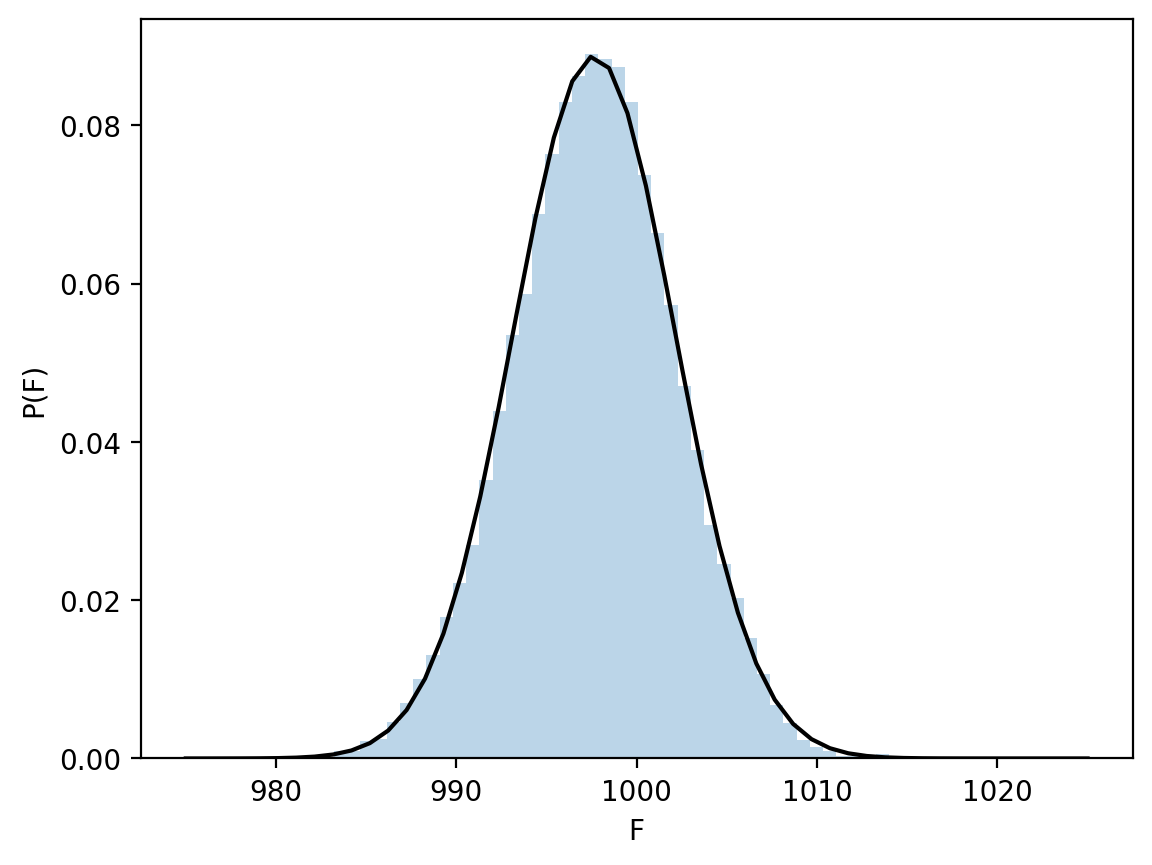

In [26]:
# plot a histogram of the sample
plt.hist(sample, bins=50, histtype="stepfilled", alpha=0.3, density=True)

# plot a best-fit Gaussian
F_fit = np.linspace(975, 1025)
pdf = stats.norm(np.mean(sample), np.std(sample)).pdf(F_fit)

plt.plot(F_fit, pdf, '-k')


plt.xlabel("F"); plt.ylabel("P(F)")

We end up with a sample of points drawn from the (normal) posterior distribution. The mean and standard deviation of this posterior are the corollary of the frequentist maximum likelihood estimate above:

In [27]:
print("""
      F_true = {0}
      F_est  = {1:.0f} +/- {2:.0f} (based on {3} measurements)
      """.format(F_true, np.mean(sample), np.std(sample), N))



      F_true = 1000
      F_est  = 998 +/- 4 (based on 50 measurements)
      




We see that, as expected for this simple problem, the Bayesian approach here yields the same result as the frequentist approach.

This might give you the impression that the Bayesian method is unnecessarily complicated without improving any results.
Here, this is the case: Using an Affine Invariant Markov Chain Monte Carlo Ensemble sampler to characterize a one-dimensional normal distribution is overly complicated. However, we did this here to demonstrate an approach, and this approach is usually applied to complicated posteriors that can be a) highly multidimensional, b) have likelihoods and posteriors that are complicated to "explore" as they might be anything but a Gaussian. 

In these cases, using a MCMC algorithm like the Affine Invariant Markov Chain Monte Carlo Ensemble sampler is a way to a) provice nice results b) within a reasonable computational time (instead of, for example, maximizing posteriors on a grid in parameter space).

When we computed the sample mean and standard deviation above, we were employing a **frequentist** technique to characterize the posterior distribution. 


<font color='red'>What would be the pure Bayesian result for this problem?</font> 


### Comparing a More Sophisticated Model

Let's now take a look at a more complicated situation, and compare the frequentist and Bayesian results yet again. So far, we assumed that the star was static. Now we assume that we're looking at an object which we suspect has some stochastic variation — that is, it varies with time, but in an unpredictable way (a Quasar is a good example of such an object).

We'll propose a simple 2-parameter Gaussian model for this object: $\theta = [\mu,\sigma]$ where $\mu$ is the mean value, and $\sigma$ is the standard deviation of the variability intrinsic to the object. Thus our model for the probability of the true flux at the time of each observation is:

$$F_{true} \sim \frac{1}{\sqrt{2\pi\sigma^2}}\exp \left[ \frac{-(F-\mu)^2}{2\sigma^2}    \right]$$

Now, we'll again consider $N$ observations each with their own error. We generate them:

In [29]:
np.random.seed(42)  # for reproducibility
N = 100  # we'll use more samples for the more complicated model
mu_true, sigma_true = 1000, 15  # stochastic flux model

F_true = stats.norm(mu_true, sigma_true).rvs(N)  # (unknown) true flux
F = stats.poisson(F_true).rvs()  # observed flux: true flux plus Poisson errors.
e = np.sqrt(F)  # root-N error, as above

**The Frequentist Approach**

The resulting likelihood is the convolution of the intrinsic distribution with the error distribution, so we have

$$L(D|\theta) = \prod_{i=1}^N \frac{1}{\sqrt{2\pi(\sigma^2 + e_i^2)    }}  \exp \left[ \frac{-(F_i-\mu)^2}{2(\sigma^2 + e_i^2)} \right]  $$

As before, we can analytically maximize this likelihood (which is not always the case!).

Here we find the best estimate for $\mu$:
    
$$\mu_{est} = \frac{\sum \omega_i F_i}{\sum \omega_i}$$
    
with

$$w_i = \frac{1}{\sigma^2 + e_i^2}$$

From this equation we see were our problem lies: The (optimal) value of $\mu$ depends on the optimal value of $\sigma$. Thus, the results are correlated, so we can no longer use straightforward analytic methods to arrive at the frequentist result.

What we can do is using **numerical optimization techniques** to determine the maximum likelihood value. Here we'll use the optimization routines available within `scipy.optimize`:


In [30]:
def log_likelihood(theta, F, e):
    return -0.5 * np.sum(np.log(2 * np.pi * (theta[1] ** 2 + e ** 2))
                         + (F - theta[0]) ** 2 / (theta[1] ** 2 + e ** 2))

# maximize likelihood <--> minimize negative likelihood
def neg_log_likelihood(theta, F, e):
    return -log_likelihood(theta, F, e)

from scipy import optimize
theta_guess = [900, 5]
theta_est = optimize.fmin(neg_log_likelihood, theta_guess, args=(F, e))
print("""
      Maximum likelihood estimate for {0} data points:
          mu={theta[0]:.0f}, sigma={theta[1]:.0f}
      """.format(N, theta=theta_est))

Optimization terminated successfully.
         Current function value: 502.839505
         Iterations: 58
         Function evaluations: 114

      Maximum likelihood estimate for 100 data points:
          mu=999, sigma=19
      


This maximum likelihood value gives our best estimate of the parameters $\mu$ and $\sigma$ from our model. But this is only half the answer: we need to determine how confident we are in this answer, that is, we need to compute the error bars on $\mu$ and $\sigma$.


There are several approaches to **determining errors in a frequentist paradigm**. We could, as above, fit a normal approximation to the maximum likelihood and report the covariance matrix (here we'd have to do this numerically rather than analytically). Alternatively, we can compute statistics like $\chi^2$
and $\chi_{d.o.f.}^2$ and use standard tests to determine confidence limits, which also depends on strong assumptions about the Gaussianity of the likelihood. (**This likelihood is Gaussian, but many are not.**) We might alternatively use randomized sampling approaches such as Jackknife or Bootstrap, which maximize the likelihood for randomized samples of the input data in order to explore the degree of certainty in the result.

All of these would be valid techniques to use, but each comes with its own assumptions and subtleties. Here, for simplicity, we'll use the basic bootstrap resampler from the `astroML` package:

In [31]:
from astroML.resample import bootstrap

def fit_samples(sample):
    # sample is an array of size [n_bootstraps, n_samples]
    # compute the maximum likelihood for each bootstrap.
    return np.array([optimize.fmin(neg_log_likelihood, theta_guess,
                                   args=(F, np.sqrt(F)), disp=0)
                     for F in sample])

samples = bootstrap(F, 1000, fit_samples)  # 1000 bootstrap resamplings


Now in a similar manner to what we did above for the MCMC Bayesian posterior, we'll compute the sample mean and standard deviation to determine the **errors on the parameters.**


In [32]:
mu_samp = samples[:, 0]
sig_samp = abs(samples[:, 1])

print ("mu    = {0:.0f} +/- {1:.0f}".format(mu_samp.mean(), mu_samp.std()))
print ("sigma = {0:.0f} +/- {1:.0f}".format(sig_samp.mean(), sig_samp.std()))



mu    = 999 +/- 4
sigma = 18 +/- 5


We used this here to get an idea of the frequentist approach to this problem.
We aren't going into detail of the bootstrap resampling here; if you are interested in details, there is a huge literature on that available (also online).


**The Bayesian Approach**

The Bayesian approach to this problem is almost exactly the same as it was in the previous problem. We thus can set it up by slightly modifying the above code.


In [33]:
def log_prior(theta):
    # sigma needs to be positive.
    if theta[1] <= 0:
        return -np.inf
    else:
        return 0

def log_posterior(theta, F, e):
    return log_prior(theta) + log_likelihood(theta, F, e)

# same setup as above:
ndim, nwalkers = 2, 50
nsteps, nburn = 2000, 1000

starting_guesses = np.random.rand(nwalkers, ndim)
starting_guesses[:, 0] *= 2000  # start mu between 0 and 2000
starting_guesses[:, 1] *= 20    # start sigma between 0 and 20

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[F, e])
sampler.run_mcmc(starting_guesses, nsteps)

sample = sampler.chain  # shape = (nwalkers, nsteps, ndim)
sample = sampler.chain[:, nburn:, :].reshape(-1, 2)


Now that we have the samples, we'll use a convenience routine from `astroML` to plot the traces and the contours representing **one and two standard deviations**:

/home/nhernits/.local/lib/python3.10/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


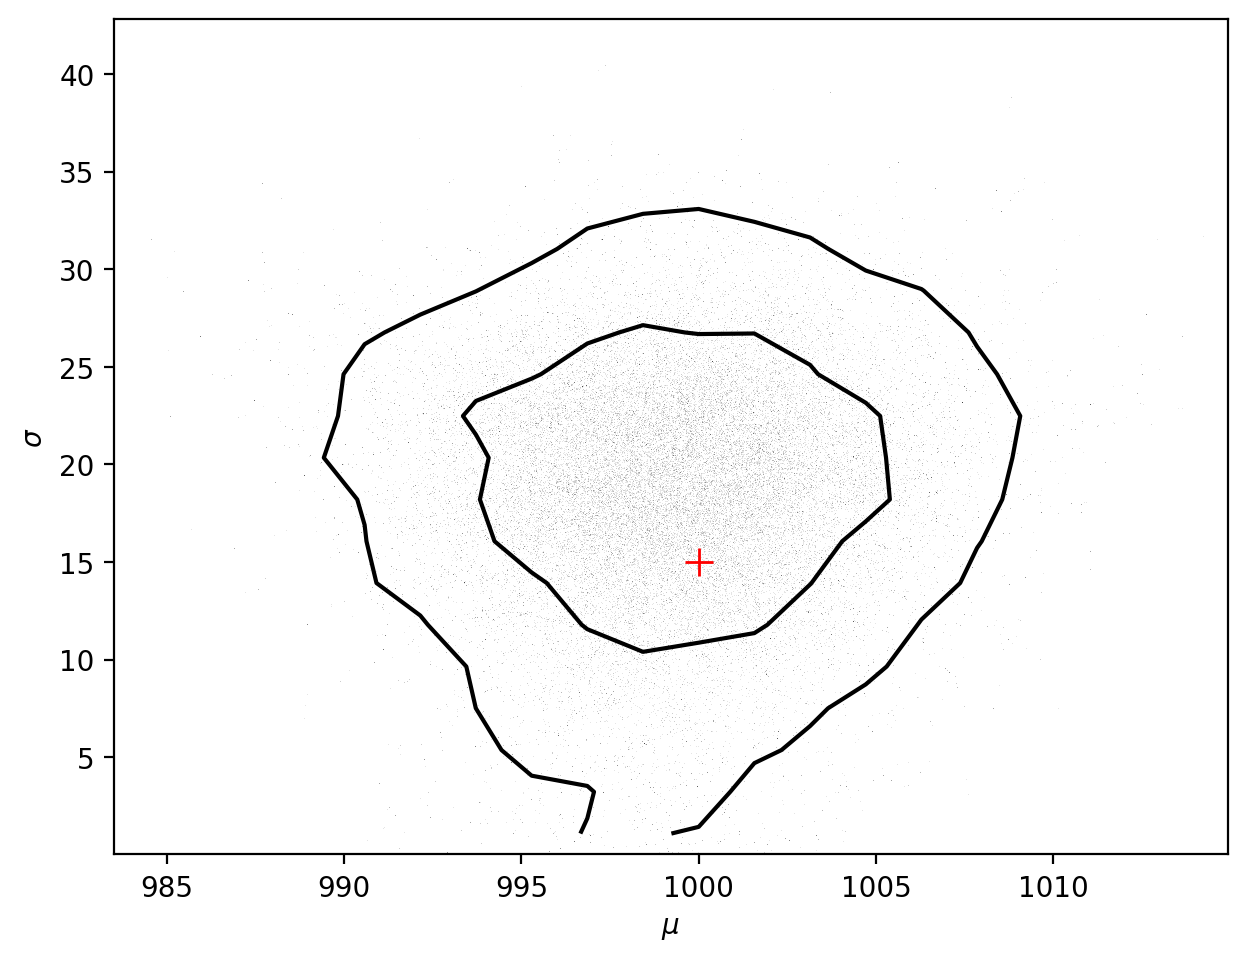

In [34]:
from astroML.plotting import plot_mcmc
fig = plt.figure()
ax = plot_mcmc(sample.T, fig=fig, labels=[r'$\mu$', r'$\sigma$'], colors='k')
ax[0].plot(sample[:, 0], sample[:, 1], ',k', alpha=0.1)
ax[0].plot([mu_true], [sigma_true], '+', color='red', ms=10);



The red + indicates ground truth (from our problem setup), and the contours indicate one and two standard deviations (68% and 95% confidence levels). In other words, based on this analysis we are 68% confident that the model lies within the inner contour, and 95% confident that the model lies within the outer contour.

Note here that a value of $\sigma = 0$ is **consistent with our data within two standard deviations**: that is, depending on the certainty threshold you're interested in, our data are not enough to confidently rule out the possibility of a non-varying source.

The other thing to notice is that this **posterior is definitely not Gaussian**: this can be seen by the lack of symmetry in the vertical direction. That means that the Gaussian approximation used within the frequentist approach may not reflect the true uncertainties in the result. This isn't an issue with frequentism itself (i.e. there are certainly ways to account for non-Gaussianity within the frequentist paradigm), but the vast majority of commonly applied frequentist techniques make the explicit or implicit assumption of Gaussianity of the distribution. Bayesian approaches generally don't require such assumptions. **Many problems we will deal with in astrostatistics have non-Gaussian distributions.**

### Conclusion


To summarize the differences between the frequentist and the Bayesian approach:

* Frequentism considers probabilities to be related to frequencies of real or hypothetical events.
* Bayesianism considers probabilities to measure degrees of knowledge.
* Frequentist analyses generally proceed through use of point estimates and maximum likelihood approaches.
* Bayesian analyses generally compute the posterior either directly or through some version of MCMC sampling.

In simple problems, the two approaches can yield similar results. As data and models grow in complexity, however, the two approaches can diverge greatly.

## Summary <a class="anchor" id="fourth-bullet"></a>

At this point, all of you should have:
* an idea of what Frequentist and Bayesian Statistical Inference mean
* an understanding of what Maximum Likelihood Estimation is
* seen how we quantify uncertainties of Maximum Likelihood estimates